Starter code taken from this online blog post

https://towardsdatascience.com/network-analysis-to-quickly-get-insight-into-an-academic-field-with-python-cd891717d547

In [5]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm

Entrez.email = "awyeh450471@gmail.com"

keyword = "hay fever"

result = Entrez.read(Entrez.esearch(db="pubmed", retmax=10, term=keyword))
print(
    "Total number of publications that contain the term {}: {}".format(
        keyword, result["Count"]
    )
)

MAX_COUNT = result["Count"]
result = Entrez.read(
    Entrez.esearch(db="pubmed", retmax=result["Count"], term=keyword)
)

ids = result["IdList"]

batch_size = 100
batches = [ids[x: x + 100] for x in range(0, len(ids), batch_size)]

record_list = []
for batch in tqdm(batches):
    h = Entrez.efetch(db="pubmed", id=batch, rettype="medline", retmode="text")
    records = Medline.parse(h)
    record_list.extend(list(records))
print("Complete.")

Total number of publications that contain the term hay fever: 15769


100%|████████████████████████████████████████| 158/158 [03:13<00:00,  1.23s/it]

Complete.


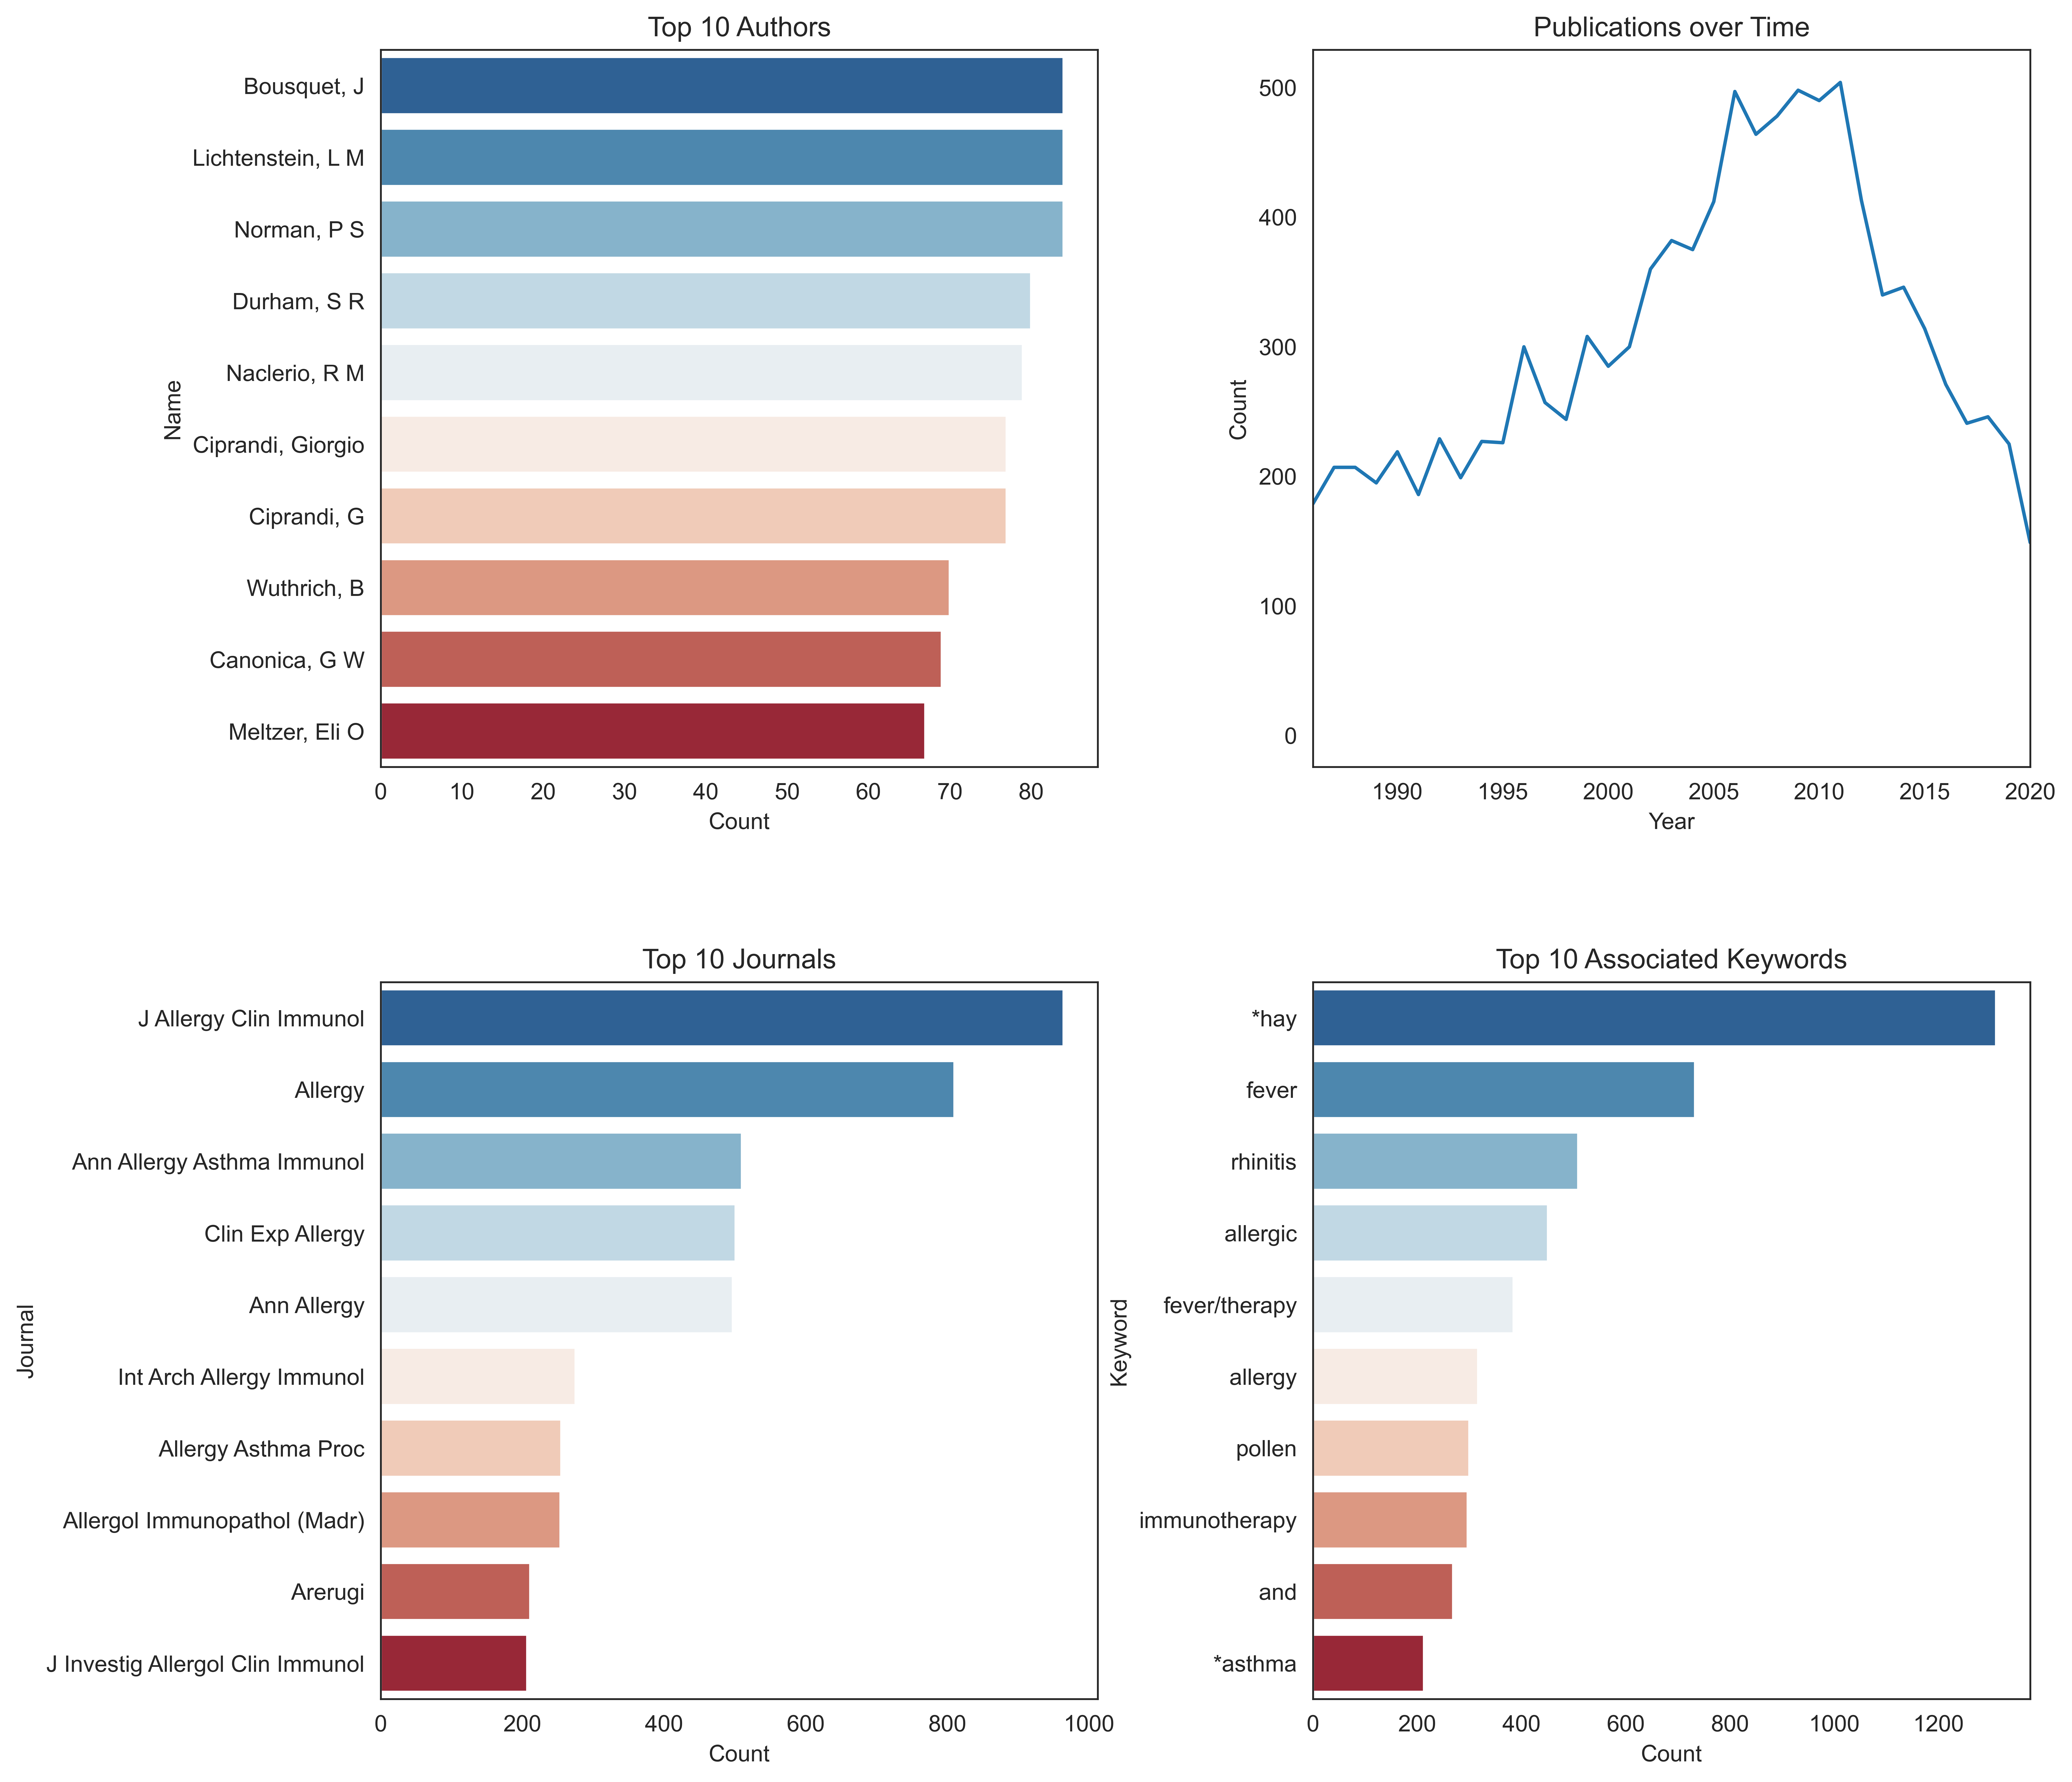

In [10]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("white")

publication_data = pd.DataFrame(record_list)
publication_data.dropna(subset=['EDAT'], inplace=True)
publication_data["Year"] = (
    publication_data["EDAT"].astype(str).str[0:4].astype(int)
)

plt.figure(figsize=(10, 10), dpi=600)

# Top 10 authors
plt.subplot(2, 2, 1)
authors_flat = [
    author
    for authors in list(publication_data["FAU"].dropna())
    for author in authors
]
top10authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(10), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")


# Publications over Time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(publication_data["Year"].value_counts().reset_index())
yearly.columns = ["Year", "Count"]
sns.lineplot(x="Year", y="Count", data=yearly)
plt.title("Publications over Time")
plt.xlim([1986, 2020])


plt.subplot(2, 2, 3)

# TOP 10 Journals
top10journals = pd.DataFrame.from_records(
    Counter(publication_data["TA"]).most_common(10),
    columns=["Journal", "Count"],
)

sns.barplot(x="Count", y="Journal", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Journals")

# Top associated keywords
plt.subplot(2, 2, 4)

flat_kw = [
    _.lower()
    for kws in list(publication_data["OT"].dropna())
    for kw in kws
    for _ in kw.split(" ")
]

top10kw = pd.DataFrame.from_records(
    Counter(flat_kw).most_common(10), columns=["Keyword", "Count"]
)

sns.barplot(x="Count", y="Keyword", data=top10kw, palette="RdBu_r")
plt.title("Top 10 Associated Keywords")
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.3, wspace=0.3)
plt.show()

In [11]:
top10kw

,Keyword,Count
0,*hay,1310
1,fever,733
2,rhinitis,509
3,allergic,451
4,fever/therapy,385
5,allergy,317
6,pollen,300
7,immunotherapy,297
8,and,269
9,*asthma,213


In [12]:
publication_data['AU']

0        [Wijga AH, Gehring U, van de Putte EM, Koppelm...
1        [Bui DS, Lodge CJ, Perret JL, Lowe A, Hamilton...
2        [Sahebjada S, Chan E, Xie J, Snibson GR, Danie...
3                                                      NaN
4        [Wang M, She W, Yang J, Wang X, Zhang Y, Zhang...
                               ...                        
15764                                        [Mackenzie M]
15765                                          [Waters AT]
15766                                        [Thompson ES]
15767                                         [Kirkman WP]
15768                                           [Scott RW]
Name: AU, Length: 15769, dtype: object

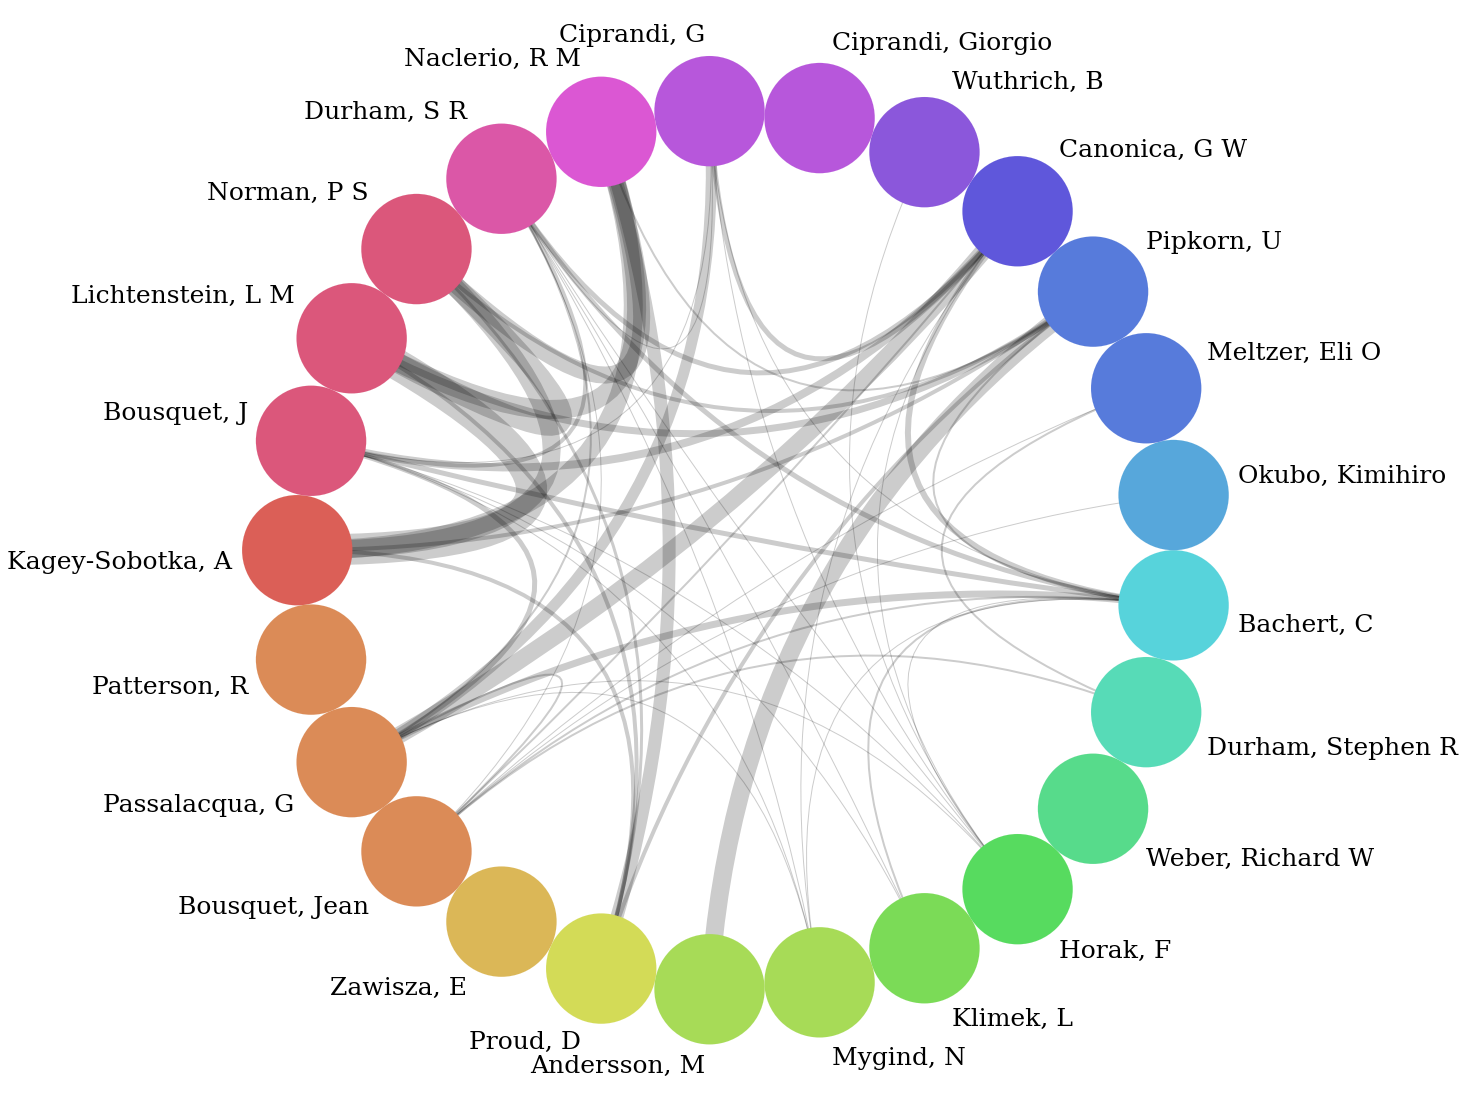

<Figure size 432x288 with 0 Axes>

In [25]:
from itertools import combinations
import networkx as nx
from nxviz.plots import CircosPlot

# Extract author connections
authors = publication_data["FAU"].dropna()
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = [item for sublist in author_connections for item in sublist]

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]


G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)

# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(25), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))

G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes():
    G_50.nodes[n]["publications"] = int(
        top50authors[top50authors["Name"] == n]["Count"]
    )


c = CircosPlot(
    G_50,
    dpi=600,
    node_grouping="publications",
    edge_width="Count",
    figsize=(20, 20),
    node_color="publications",
    node_labels=True,
    fontsize = 25
)
c.draw()
plt.show()
plt.savefig('author_connections.png', dpi=300, bbox_inches='tight', transparent = True)

In [15]:
authors_flat

['Wijga, Alet H',
 'Gehring, Ulrike',
 'van de Putte, Elise M',
 'Koppelman, Gerard',
 'Vader, Sarah',
 'Schmits, Ruben J H',
 'Wouden, J Hans C van der',
 'Picavet, H Susan J',
 'Bui, Dinh S',
 'Lodge, Caroline J',
 'Perret, Jennifer L',
 'Lowe, Adrian',
 'Hamilton, Garun S',
 'Thompson, Bruce',
 'Giles, Graham',
 'Tan, Daniel',
 'Erbas, Bircan',
 'Pirkis, Jane',
 'Cicuttini, Flavia',
 'Cassim, Raisa',
 'Bowatte, Gayan',
 'Thomas, Paul',
 'Garcia-Aymerich, Judith',
 'Hopper, John',
 'Abramson, Michael J',
 'Walters, Eugene H',
 'Dharmage, Shyamali C',
 'Sahebjada, Srujana',
 'Chan, Elsie',
 'Xie, Jing',
 'Snibson, Grant R',
 'Daniell, Mark',
 'Baird, Paul N',
 'Wang, Min',
 'She, Wenyu',
 'Yang, Jun',
 'Wang, Xiangdong',
 'Zhang, Yuan',
 'Zhang, Xu',
 'Zhang, Luo',
 'Sharif, Hanisah',
 'Acharya, Swati',
 'Dhondalay, Gopal Krishna R',
 'Varricchi, Gilda',
 'Krasner-Macleod, Shoshanna',
 'Laisuan, Wannada',
 'Switzer, Amy',
 'Lenormand, Madison',
 'Kashe, Elena',
 'Parkin, Rebecca V',
 

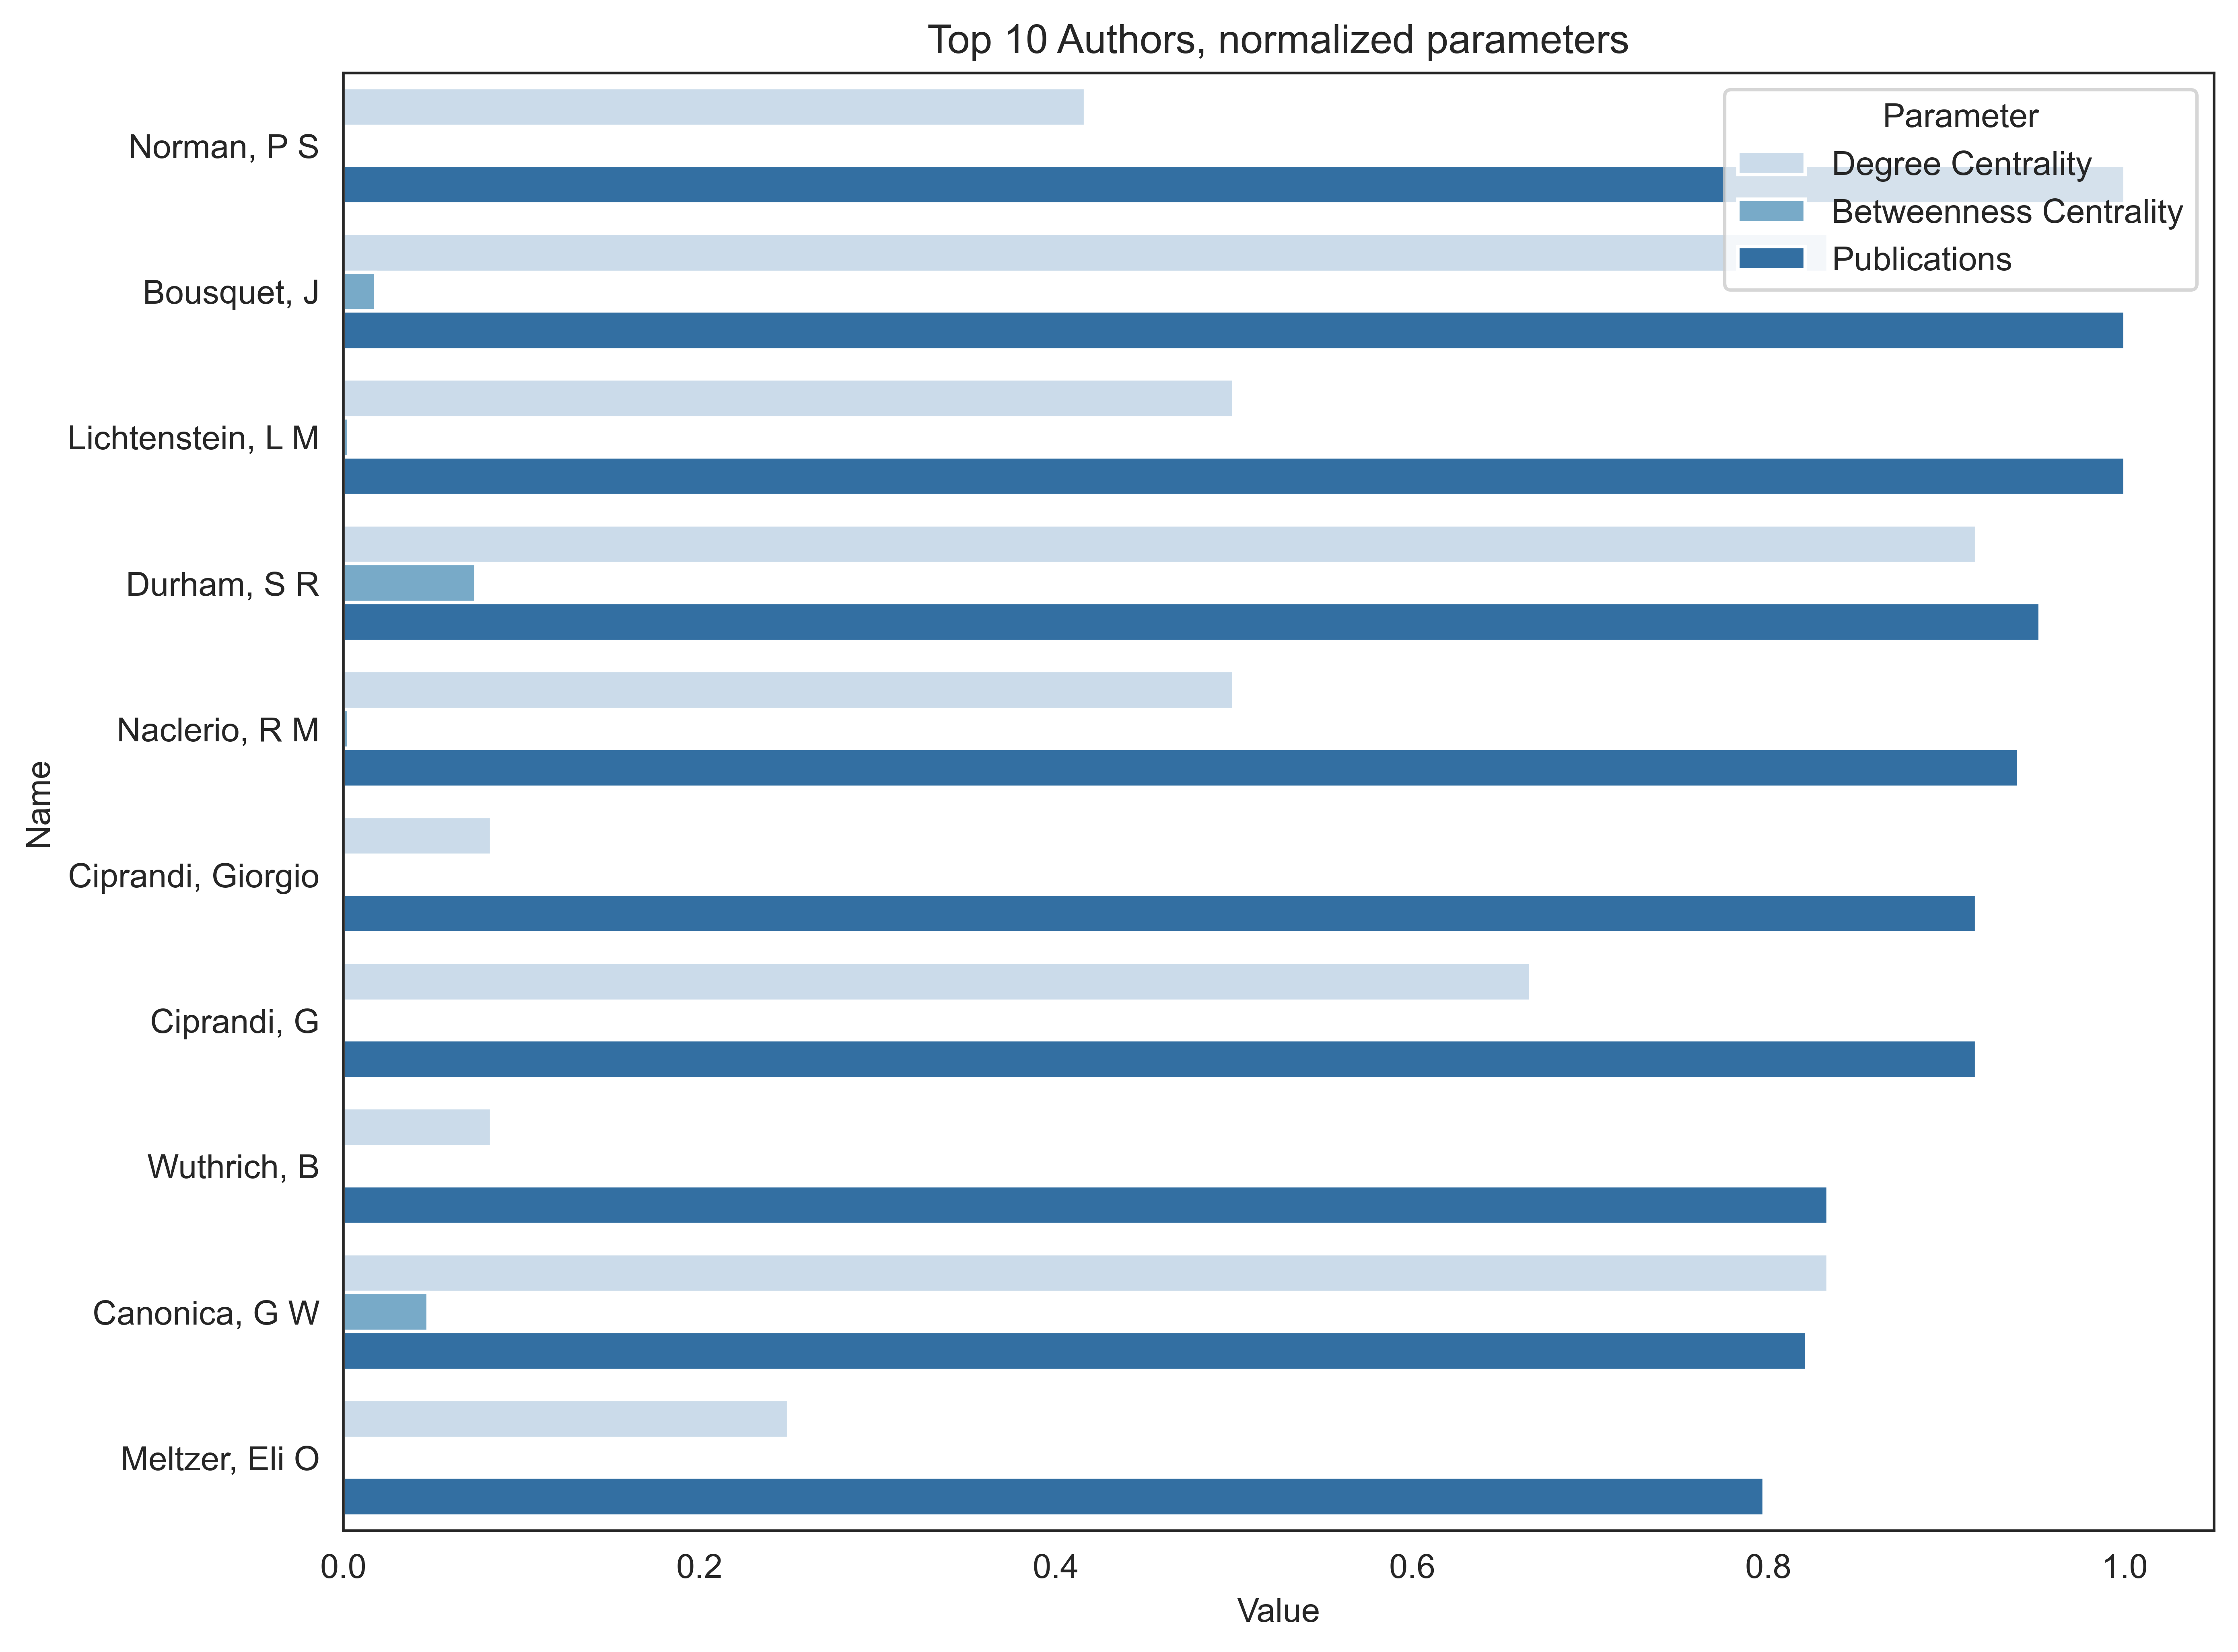

In [16]:
## Network analysis
deg = nx.degree_centrality(G_50)
bet = nx.betweenness_centrality(G_50)

top_df = pd.DataFrame.from_dict(
    [deg, bet, dict(Counter(authors_flat).most_common(50))]
).T
top_df.columns = [
    "Degree Centrality",
    "Betweenness Centrality",
    "Publications",
]

for col in top_df.columns:
    top_df[col] = top_df[col] / max(top_df[col])

top_df = top_df.sort_values("Publications", ascending=False)[:10]
top_df = pd.DataFrame(top_df.stack())
top_df = top_df.reset_index()
top_df.columns = ["Name", "Parameter", "Value"]


fig, ax = plt.subplots(figsize=(10, 8), dpi=600)

sns.barplot(x="Value", y="Name", data=top_df, hue="Parameter", palette="Blues")

plt.title("Top 10 Authors, normalized parameters")
plt.show()

In [17]:
paths = list(
    nx.all_shortest_paths(G, source="Ha, Taekjip", target="Bustamante, Carlos")
)

for path in paths:
    print(path)

NodeNotFound: Source Ha, Taekjip not in G

In [ ]:
publication_data.columns

In [ ]:
publication_data['RF'].shape

In [ ]:
publication_data.dropna(subset = ['RF'])['RF'].astype(int).sort_values(ascending = False).reset_index(drop = True)

In [ ]:
publication_data.sort_values(by = ['RF'], ascending = True)

In [ ]:
publication_data['OT'][0]